In [188]:
#! pip -q install pandas matplotlib
#! pip install -q scikit-learn
#! pip install -q joblib
#! pip install -q tensorflow

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import joblib


pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [190]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [191]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'date', 'mov_change', 'blackout', 'shutdown', 'holiday', 'winter_school_holidays', 'holiday_name', 'school_holidays', 'mini_shutdown', 'shops_closed', 'frankfurt_shutdown', 'warehouse', 'snow', 'precipitation'}
No differences found in column: mov_change
No differences found in column: blackout
No differences found in column: shutdown
No differences found in column: holiday
No differences found in column: winter_school_holidays
No differences found in column: holiday_name
No differences found in column: school_holidays
No differences found in column: mini_shutdown
No differences found in column: shops_closed
No differences found in column: frankfurt_shutdown
No differences found in column: snow
No differences found in column: precipitation

Success. All values match across the datasets, datasets merged.
{'date', 'winter_school_holidays', 'holiday', 'holiday_name', 'school_holidays', 'shops_closed', 'warehouse'}
No differences found in column: winter_school_holidays
No differences found

In [192]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [193]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['user_activity_2', 'mov_change', 'blackout', 'shutdown', 'mini_shutdown', 'warehouse_limited', 'frankfurt_shutdown', 'user_activity_1', 'snow', 'precipitation']


In [194]:
train_df = train_df.drop(columns=unavailable_features)

In [195]:
# list redundant columns that have unchanging values
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [196]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [197]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [198]:
test_df.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
61,Brno_1,2024-03-16,NaN,0,0,0,0,Brno_1_2024-03-16
340,Budapest_1,2024-03-16,NaN,0,0,0,0,Budapest_1_2024-03-16
292,Frankfurt_1,2024-03-16,NaN,0,0,0,0,Frankfurt_1_2024-03-16
244,Munich_1,2024-03-16,NaN,0,0,0,0,Munich_1_2024-03-16
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16


In [199]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [200]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [201]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [202]:
train_df.head(10)

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
1193,Brno_1,2020-12-05,6447.0,NaN,0,0,0,0,Brno_1_2020-12-05
6186,Budapest_1,2020-12-05,4623.0,NaN,0,0,0,0,Budapest_1_2020-12-05
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,Prague_1_2020-12-05
2386,Prague_2,2020-12-05,4154.0,NaN,0,0,0,0,Prague_2_2020-12-05
3579,Prague_3,2020-12-05,4091.0,NaN,0,0,0,0,Prague_3_2020-12-05
1194,Brno_1,2020-12-06,5338.0,NaN,0,0,0,0,Brno_1_2020-12-06
6187,Budapest_1,2020-12-06,4197.0,NaN,0,0,0,0,Budapest_1_2020-12-06
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,Prague_1_2020-12-06
2387,Prague_2,2020-12-06,4016.0,NaN,0,0,0,0,Prague_2_2020-12-06
3580,Prague_3,2020-12-06,3972.0,NaN,0,0,0,0,Prague_3_2020-12-06


In [203]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['days_since_start'] = (df.index - df.index.min()).days
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    #df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    #df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    time_features = ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos']
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    binary_features = ['is_weekend']
    return df, time_features, categorical_features, binary_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [204]:
train_df, time_features, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

In [205]:
train_df = train_df.drop(columns=['holiday_name']) 

### Plot

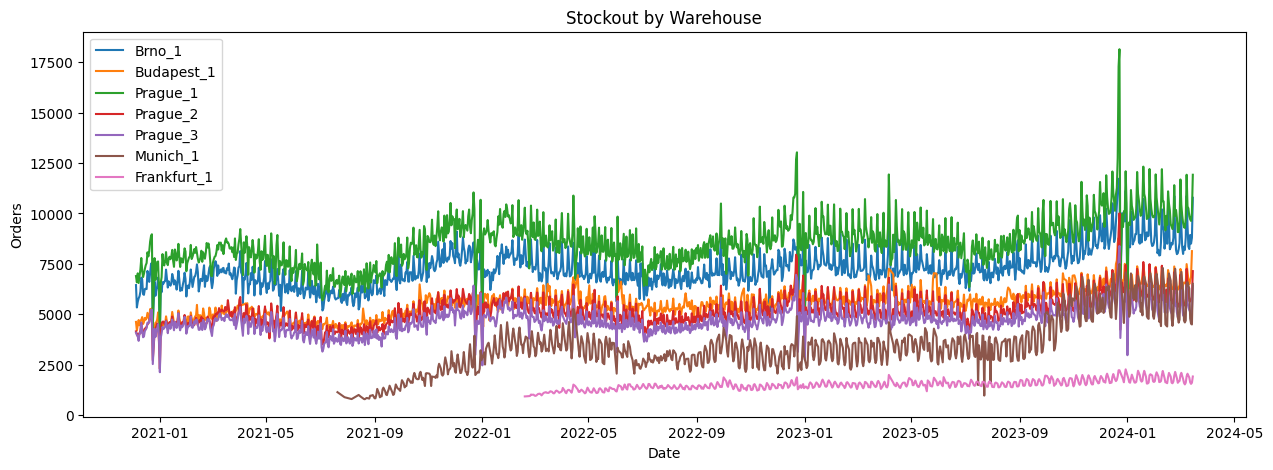

In [206]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

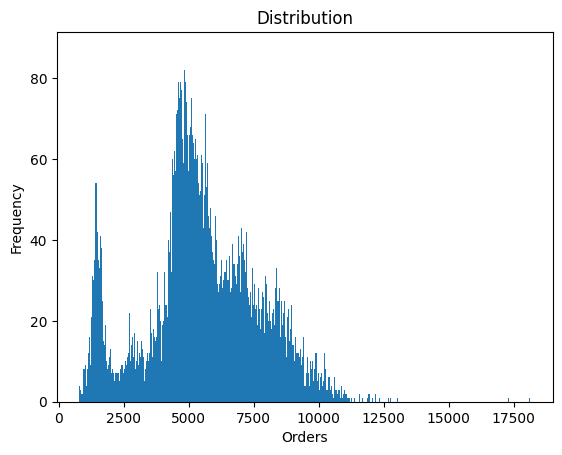

In [207]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

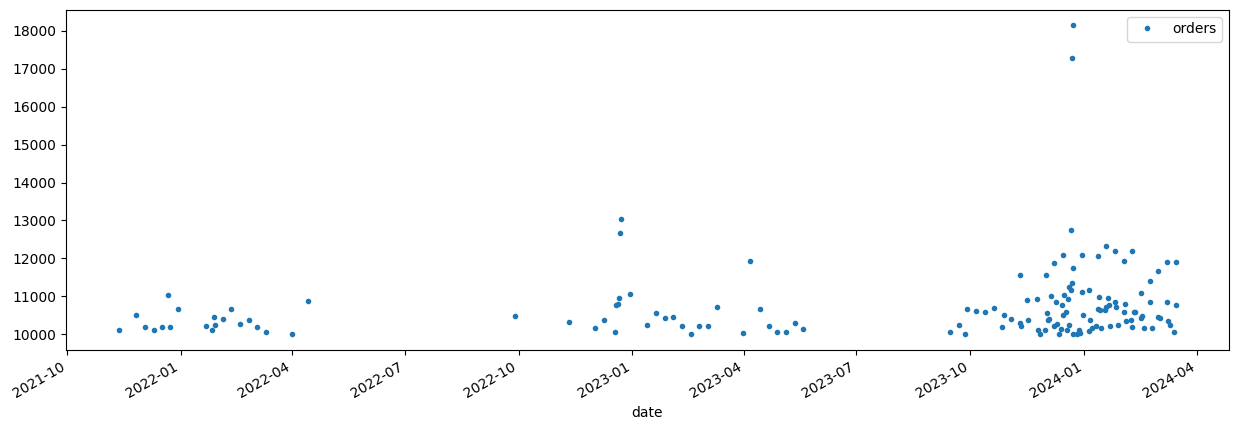

In [208]:
train_df.query('orders > 10000').plot(y='orders', figsize=(15, 5), style='.')

In [209]:

Q1 = train_df['orders'].quantile(0.25)
Q3 = train_df['orders'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 2.1 * IQR


iqr_outliers = train_df[(train_df['orders'] < lower_bound) | (train_df['orders'] > upper_bound)]

# Print number of outliers identified by each method
print(f"Number of IQR outliers: {iqr_outliers.shape[0]}")

iqr_outliers.head()


Number of IQR outliers: 5


,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,
2022-12-22,Prague_1,12661.0,0,0,0,0,Prague_1_2022-12-22,4,2022,12,22,3,356,0,747,-2.639248e-09,2022.0,-3.526983e-14,12.0
2022-12-23,Prague_1,13028.0,0,0,0,0,Prague_1_2022-12-23,4,2022,12,23,4,357,0,748,-2.639248e-09,2022.0,-3.526983e-14,12.0
2023-12-21,Prague_1,12744.0,0,0,0,0,Prague_1_2023-12-21,4,2023,12,21,3,355,0,1111,-1.304240e-09,2023.0,-3.526983e-14,12.0
2023-12-22,Prague_1,17282.0,0,0,0,0,Prague_1_2023-12-22,4,2023,12,22,4,356,0,1112,-1.304240e-09,2023.0,-3.526983e-14,12.0
2023-12-23,Prague_1,18139.0,0,0,0,0,Prague_1_2023-12-23,4,2023,12,23,5,357,1,1113,-1.304240e-09,2023.0,-3.526983e-14,12.0


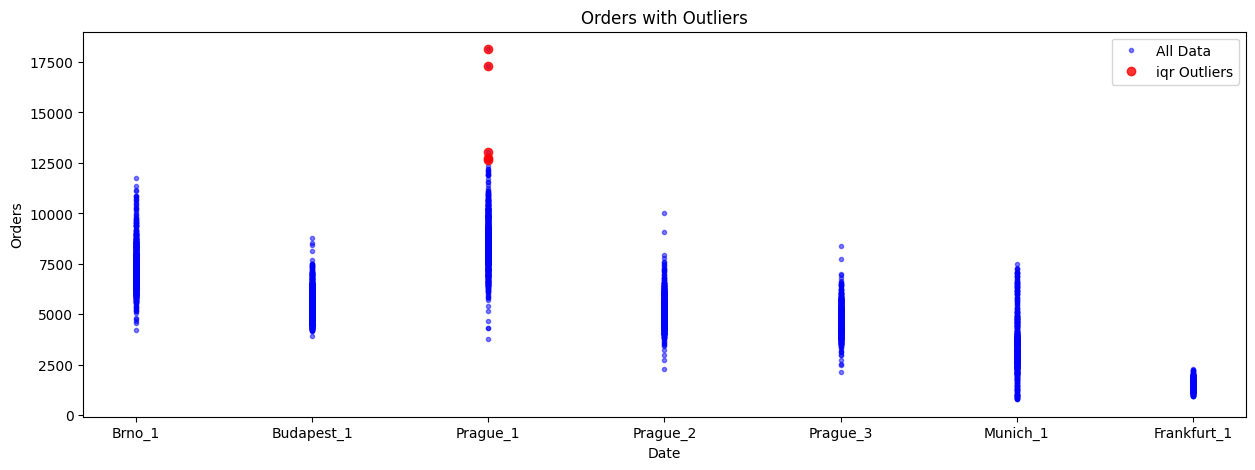

In [210]:
# Plot all data points
plt.figure(figsize=(15, 5))
plt.plot(train_df.warehouse, train_df['orders'], 'b.', alpha=0.5, label='All Data')

# Highlight outliers
plt.plot(iqr_outliers.warehouse, iqr_outliers['orders'], 'ro', alpha=0.8, label='iqr Outliers')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Orders with Outliers')
plt.legend()
plt.show()

In [211]:
# Drop outliers
#train_df = train_df.drop(iqr_outliers.index)

# Do not drop outliers but fix their values to be average

train_df.loc[iqr_outliers.index, 'orders'] = train_df['orders'].mean()

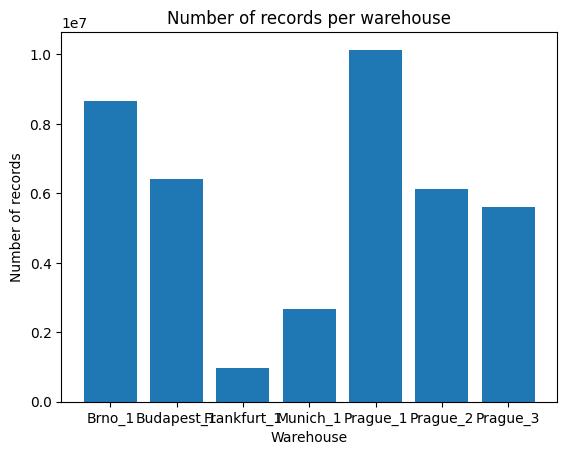

In [212]:
whs = train_df.groupby('warehouse')['orders'].sum()

plt.bar(whs.index, whs.values)
plt.xlabel('Warehouse')
plt.ylabel('Number of records')
plt.title('Number of records per warehouse')
plt.show()

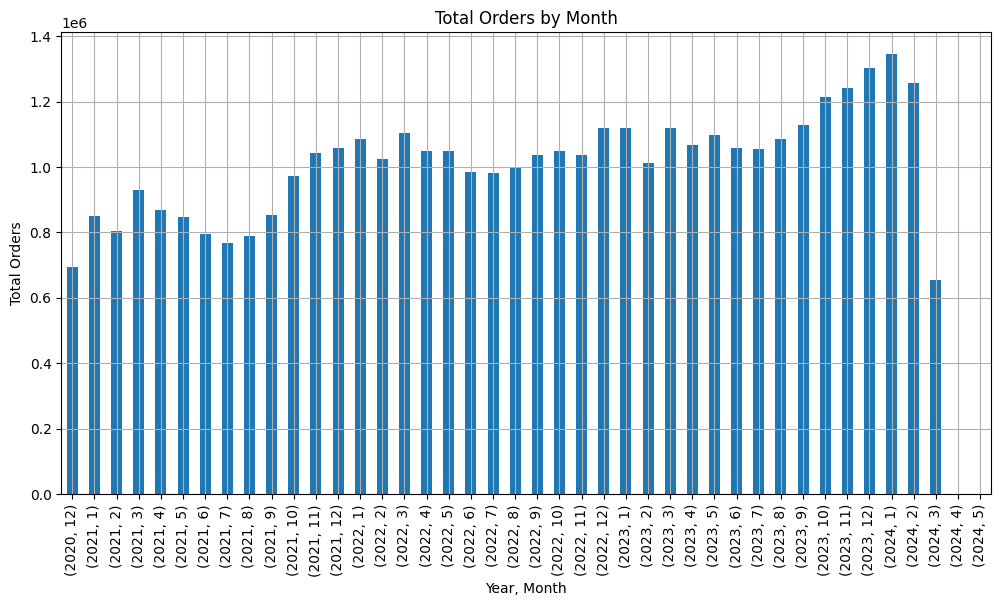

In [213]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

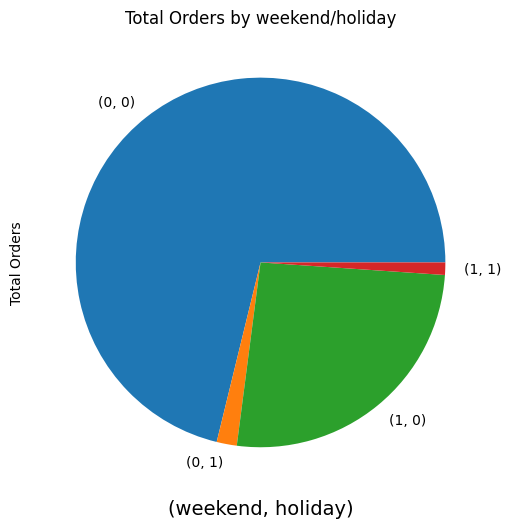

In [214]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [215]:
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

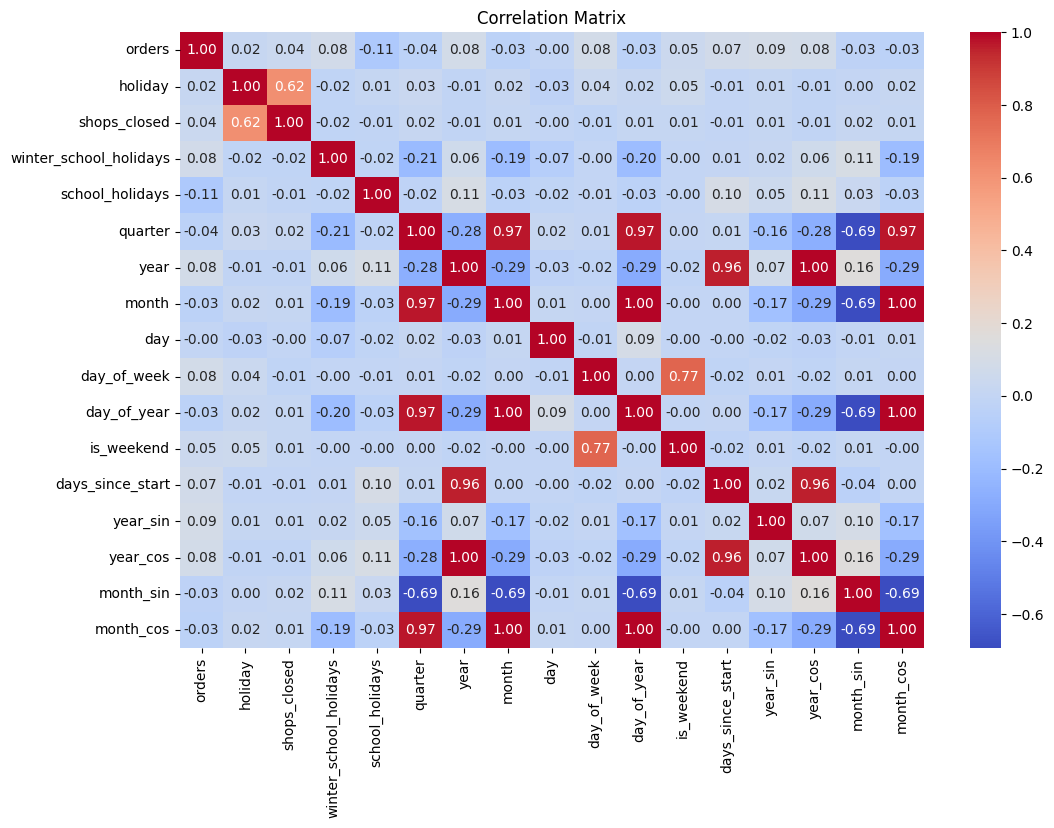

orders                    1.000000
year_sin                  0.089860
day_of_week               0.084234
year_cos                  0.083276
year                      0.083276
winter_school_holidays    0.079056
days_since_start          0.074959
is_weekend                0.046539
shops_closed              0.035803
holiday                   0.019158
day                      -0.001565
month_sin                -0.026262
day_of_year              -0.033856
month                    -0.034498
month_cos                -0.034498
quarter                  -0.037287
school_holidays          -0.105731
Name: orders, dtype: float64


In [216]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Temporal features

In [217]:
LAG_DAYS = [28, 56, 168, 364]
ROLLING_WINDOW = [28, 168, 364]

In [218]:
def create_lag_features(df, col, lag_days):
    df = df.copy()  # Create a copy to avoid SettingWithCopyWarning
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()  # Create a copy to avoid SettingWithCopyWarning
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[std_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

In [219]:
# Apply the functions
train_df, lag_features = create_lag_features(train_df, 'orders', LAG_DAYS)
train_df, window_features = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

# Combine the features for easier visualization
numerical_features = ['orders']
numerical_features += lag_features + window_features
categorical_features=categorical_features

print(numerical_features)

train_df.head()

['orders', 'orders_lag_28', 'orders_lag_56', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Brno_1,6447.0,0,0,0,0,Brno_1_2020-12-05,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,6447.0,NaN,6447.0,NaN,6447.0,NaN
2020-12-05,Budapest_1,4623.0,0,0,0,0,Budapest_1_2020-12-05,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,4623.0,NaN,4623.0,NaN,4623.0,NaN
2020-12-05,Prague_1,6895.0,0,0,0,0,Prague_1_2020-12-05,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,6895.0,NaN,6895.0,NaN,6895.0,NaN
2020-12-05,Prague_2,4154.0,0,0,0,0,Prague_2_2020-12-05,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,4154.0,NaN,4154.0,NaN,4154.0,NaN
2020-12-05,Prague_3,4091.0,0,0,0,0,Prague_3_2020-12-05,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,4091.0,NaN,4091.0,NaN,4091.0,NaN


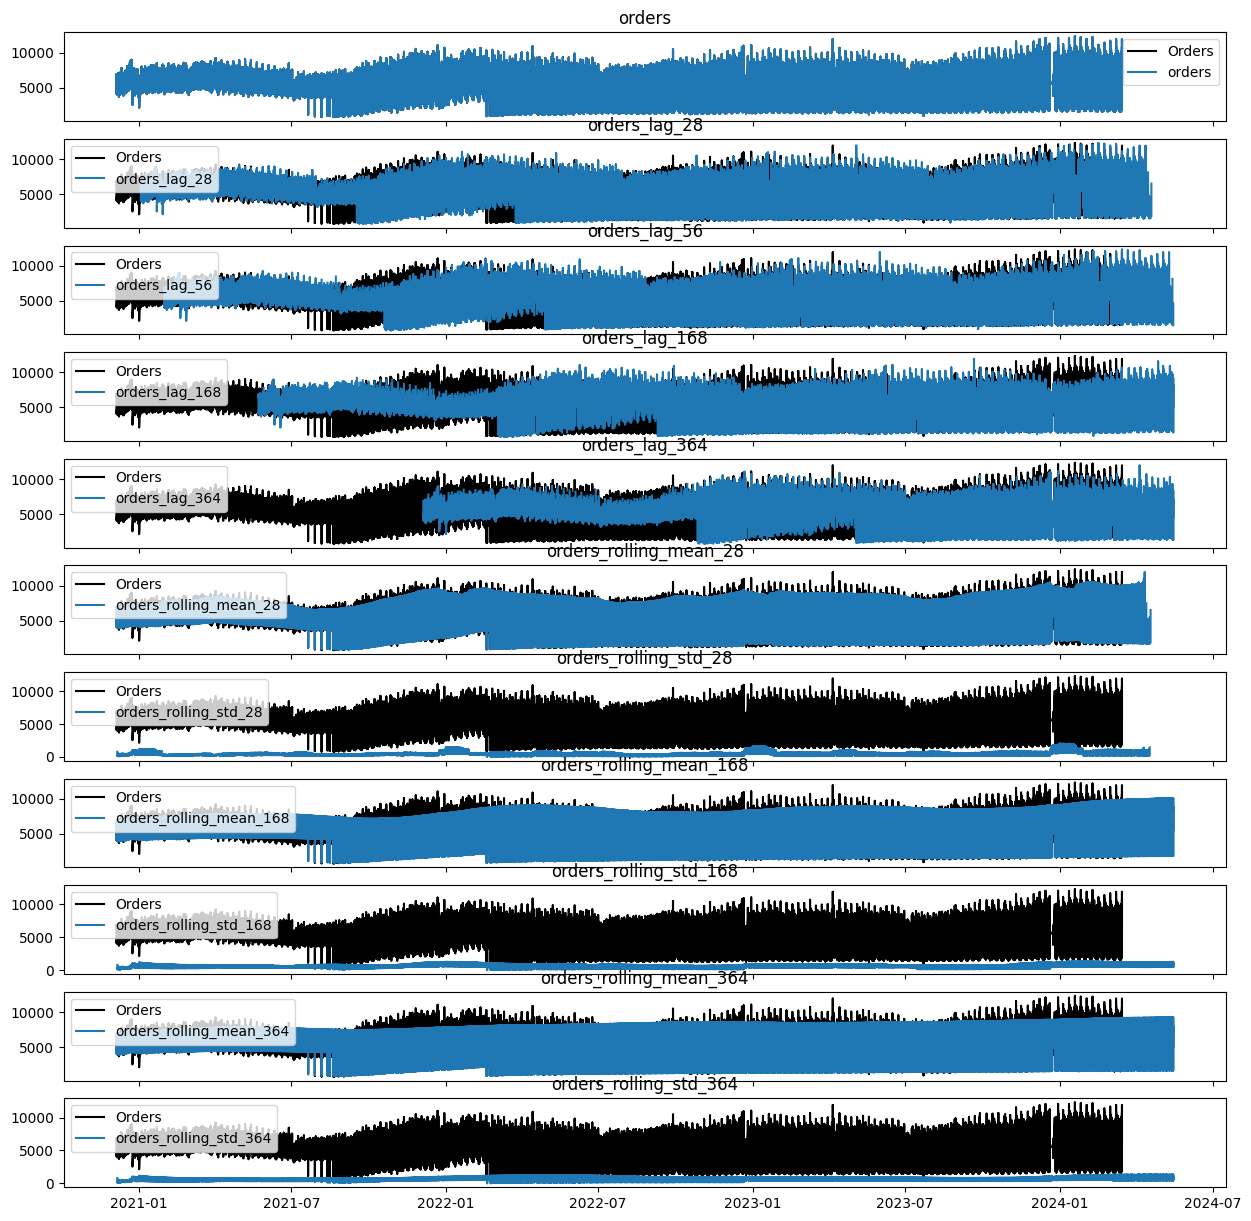

In [220]:
#orders and features above each other
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df.index, train_df['orders'], label='Orders', color='black')
    ax[i].plot(train_df.index, train_df[feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


In [221]:
# divide dataset back into train and test datasets according to the dates from the original datasets:
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
test_df["date"] = test_df.index
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

C:\Users\ondre\AppData\Local\Temp\ipykernel_20936\1761043157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["date"] = test_df.index


In [222]:
train_df.tail()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-15,Frankfurt_1,1916.0,0,0,0,0,Frankfurt_1_2024-03-15,1,2024,3,15,4,75,0,1196,3.208798e-11,2024.0,-2.204364e-15,3.0,1844.0,1611.0,1639.0,1324.0,1773.750000,193.275015,1795.222212,540.975470,1648.687724,401.973381
2024-03-15,Munich_1,6512.0,0,0,0,0,Munich_1_2024-03-15,1,2024,3,15,4,75,0,1196,3.208798e-11,2024.0,-2.204364e-15,3.0,6128.0,6454.0,3501.0,2331.0,5546.464286,1036.562463,5157.781736,1156.874414,4122.369043,1305.818685
2024-03-15,Prague_1,11917.0,0,0,0,0,Prague_1_2024-03-15,1,2024,3,15,4,75,0,1196,3.208798e-11,2024.0,-2.204364e-15,3.0,11095.0,12319.0,10668.0,8791.0,10030.214286,809.959960,9852.025783,1132.259466,9170.489922,1134.913287
2024-03-15,Prague_2,7140.0,0,0,0,0,Prague_2_2024-03-15,1,2024,3,15,4,75,0,1196,3.208798e-11,2024.0,-2.204364e-15,3.0,6773.0,7590.0,6605.0,5153.0,5990.928571,549.579498,5954.115069,604.358137,5542.182230,644.313487
2024-03-15,Prague_3,6408.0,0,0,0,0,Prague_3_2024-03-15,1,2024,3,15,4,75,0,1196,3.208798e-11,2024.0,-2.204364e-15,3.0,6203.0,6450.0,6086.0,4538.0,5366.750000,466.662351,5369.484117,530.214776,5047.473438,548.395741


In [223]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 29)
Test data: (397, 29)


In [224]:
# Save test datas for future inference
test_df.to_csv('data/test_proc_mt.csv')

In [225]:
train_df = train_df.drop(columns=['id'])

### OH encoding of categorical features

In [226]:
from sklearn.preprocessing import OneHotEncoder
import joblib

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

encoded_features = encoder.fit_transform(train_df[categorical_features])

#Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

encoded_df.index = train_df.index

train_df = pd.concat([train_df, encoded_df], axis=1)

joblib.dump(encoder, 'scaler_onehot_categorical_mt.joblib')

c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['scaler_onehot_categorical_mt.joblib']

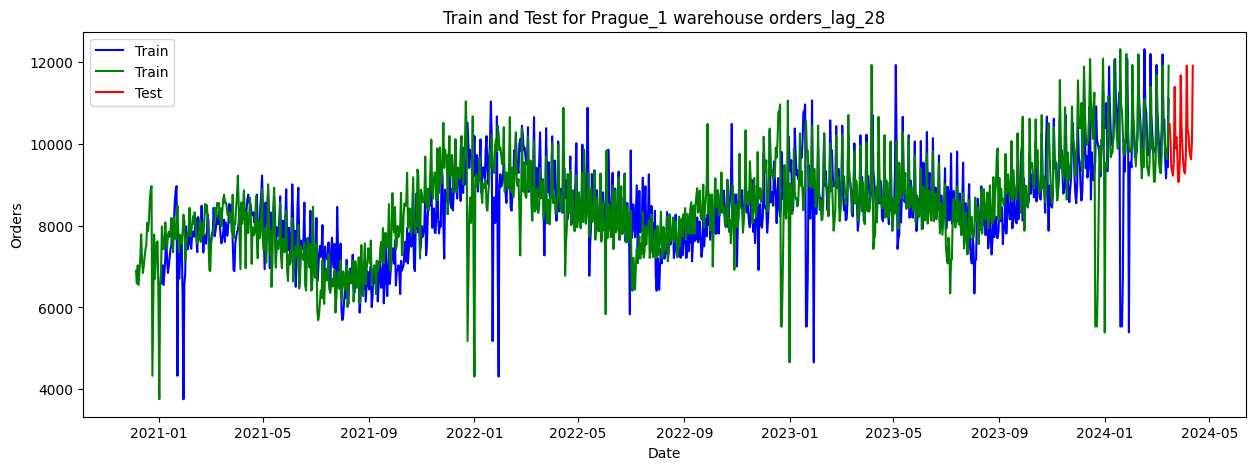

In [227]:
# plot the train and test datasets and visualise them in diferent colors for only column of prague_1 warehouse
feature = f'orders_lag_{LAG_DAYS[0]}'

plt.figure(figsize=(15, 5)) 
datax = train_df[train_df['warehouse'] == 'Prague_1']
datax_test = test_df[test_df['warehouse'] == 'Prague_1']
plt.plot(datax.index, datax[feature], label='Train', color='blue')
plt.plot(datax.index, datax['orders'], label='Train', color='green')
plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')


plt.title(f'Train and Test for Prague_1 warehouse {feature}')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

In [228]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 44)
Test data: (397, 29)


In [229]:
print(train_df.isna().sum())  # Check for Nas

warehouse                     0
orders                        0
holiday                       0
shops_closed                  0
winter_school_holidays        0
school_holidays               0
quarter                       0
year                          0
month                         0
day                           0
day_of_week                   0
day_of_year                   0
is_weekend                    0
days_since_start              0
year_sin                      0
year_cos                      0
month_sin                     0
month_cos                     0
orders_lag_28               196
orders_lag_56               392
orders_lag_168             1176
orders_lag_364             2548
orders_rolling_mean_28        0
orders_rolling_std_28         7
orders_rolling_mean_168       0
orders_rolling_std_168        7
orders_rolling_mean_364       0
orders_rolling_std_364        7
day_of_week_0                 0
day_of_week_1                 0
day_of_week_2                 0
day_of_w

In [230]:
"""lag_roll features
"""
LAG_ROLL_FEATURES = []
for feature in numerical_features:
    if 'lag' in feature or 'rolling' in feature:
        LAG_ROLL_FEATURES.append(feature)
print(LAG_ROLL_FEATURES)                                             

['orders_lag_28', 'orders_lag_56', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


In [231]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features
}

joblib.dump(scaler_config, 'scaler_config_mt.joblib')

['scaler_config_mt.joblib']

In [232]:
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())        

Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


In [233]:
# check non-continuos date timeline
train_df.index.to_series().diff().value_counts()

date
0 days    6147
1 days    1188
2 days       4
Name: count, dtype: int64

In [234]:
#Standard Scaler:
from sklearn.preprocessing import StandardScaler

def scale_data(X_train, y_train):
    # Initialize the scaler
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Fit the scaler on the numeriacal columns
    X_train_scaled = pd.DataFrame(x_scaler.fit_transform(X_train), columns=X_train.columns)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

    return X_train_scaled, y_train_scaled, x_scaler, y_scaler

In [235]:
train_df.head()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-05,Brno_1,6447.0,0,0,0,0,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,6447.0,NaN,6447.0,NaN,6447.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2020-12-05,Budapest_1,4623.0,0,0,0,0,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,4623.0,NaN,4623.0,NaN,4623.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2020-12-05,Prague_1,6895.0,0,0,0,0,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,6895.0,NaN,6895.0,NaN,6895.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2020-12-05,Prague_2,4154.0,0,0,0,0,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,4154.0,NaN,4154.0,NaN,4154.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2020-12-05,Prague_3,4091.0,0,0,0,0,4,2020,12,5,5,340,1,0,-1.630940e-09,2020.0,-3.526983e-14,12.0,NaN,NaN,NaN,NaN,4091.0,NaN,4091.0,NaN,4091.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


## Training Loop

In [236]:
def preprocess_data(df, wh):
    train_df,_ = create_lag_features(df, 'orders', LAG_DAYS)
    train_df,_ = create_rolling_features(df, 'orders', ROLLING_WINDOW)
    
    train_df = train_df.fillna(0)
    
    X_train = train_df.drop(columns=['orders'])
    y_train = train_df['orders']
    
    X_train = X_train.drop(columns=['warehouse'])
    X_train= X_train.drop(columns=categorical_features)
    X_binary = X_train[binary_features]
    X_train = X_train.drop(columns=binary_features)
        
    X_train_scaled, y_train_scaled, x_scaler, y_scaler = scale_data(X_train, y_train)
    joblib.dump(x_scaler, f'x_scaler_{wh}.joblib')
    joblib.dump(y_scaler, f'y_scaler_{wh}.joblib')
    
    X_binary = X_binary.reset_index(drop=True)
    X_train_scaled = pd.concat([X_train_scaled, X_binary], axis=1)
    
    
    return X_train_scaled, y_train_scaled, x_scaler, y_scaler

In [237]:
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    # Create sequences for each warehouse
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

In [238]:
def create_model(input_shape, lr=1e-3):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=16, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=1))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr))

    return model

In [239]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss of {warehouse}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [240]:
# Train models for each warehouse
warehouses = train_df['warehouse'].unique()

In [261]:
len(X_train.columns)

AttributeError: 'function' object has no attribute 'columns'

Training model for warehouse: Brno_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.577677 -1.211889     1.483102         -1.732070  -0.30871 -2.145151   
1  1.577677 -1.097922     1.492208         -1.729174  -0.30871 -2.145151   
2  1.577677 -0.983955     1.501315         -1.726278  -0.30871 -2.145151   
3  1.577677 -0.869988     1.510421         -1.723382  -0.30871 -2.145151   
4  1.577677 -0.756021     1.519528         -1.720486  -0.30871 -2.145151   

   month_sin  month_cos  orders_lag_28  orders_lag_56  orders_lag_168  \
0  -0.595108   1.577677      -4.975897      -3.930749       -2.384361   
1  -0.595108   1.577677      -4.975897      -3.930749       -2.384361   
2  -0.595108   1.577677      -4.975897      -3.930749       -2.384361   
3  -0.595108   1.577677      -4.975897      -3.930749       -2.384361   
4  -0.595108   1.577677      -4.975897      -3.930749       -2.384361   

   orders_lag_364  orders_rolling_mean_28  orders_rolling_std_28  \

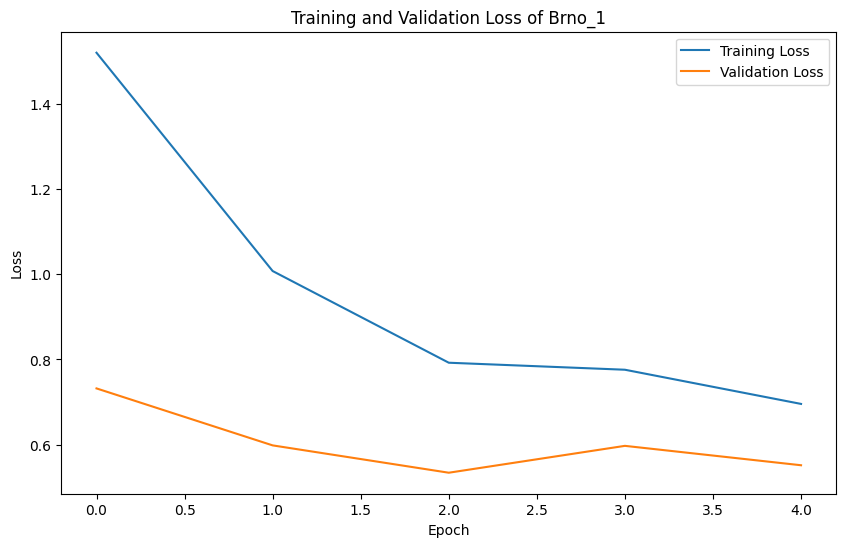

Training model for warehouse: Budapest_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.572395 -1.229544     1.479045         -1.734344 -0.309239  -2.14543   
1  1.572395 -1.114895     1.488152         -1.731448 -0.309239  -2.14543   
2  1.572395 -1.000246     1.497258         -1.728552 -0.309239  -2.14543   
3  1.572395 -0.885598     1.506365         -1.725657 -0.309239  -2.14543   
4  1.572395 -0.770949     1.515471         -1.722761 -0.309239  -2.14543   

   month_sin  month_cos  orders_lag_28  orders_lag_56  orders_lag_168  \
0  -0.594074   1.572395      -5.072721      -3.934506       -2.340207   
1  -0.594074   1.572395      -5.072721      -3.934506       -2.340207   
2  -0.594074   1.572395      -5.072721      -3.934506       -2.340207   
3  -0.594074   1.572395      -5.072721      -3.934506       -2.340207   
4  -0.594074   1.572395      -5.072721      -3.934506       -2.340207   

   orders_lag_364  orders_rolling_mean_28  orders_rolling_std_2

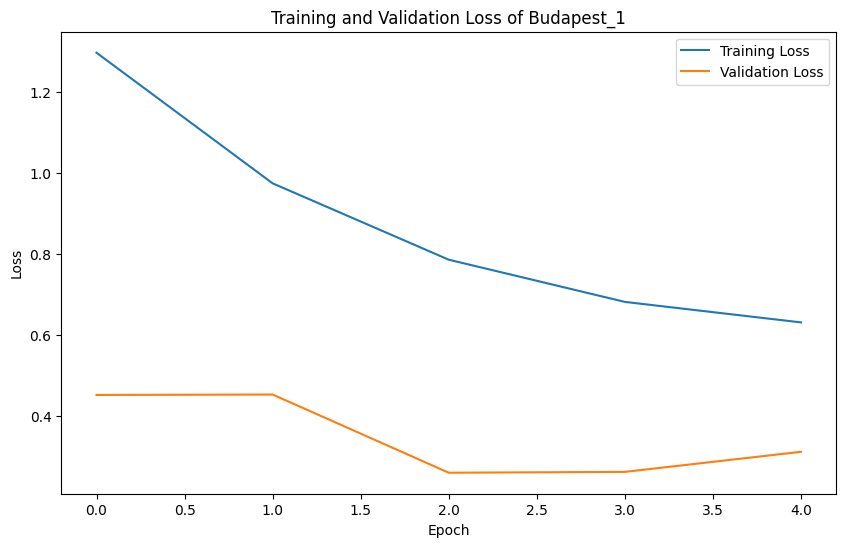

Training model for warehouse: Prague_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.577677 -1.211889     1.483102         -1.732070  -0.30871 -2.145151   
1  1.577677 -1.097922     1.492208         -1.729174  -0.30871 -2.145151   
2  1.577677 -0.983955     1.501315         -1.726278  -0.30871 -2.145151   
3  1.577677 -0.869988     1.510421         -1.723382  -0.30871 -2.145151   
4  1.577677 -0.756021     1.519528         -1.720486  -0.30871 -2.145151   

   month_sin  month_cos  orders_lag_28  orders_lag_56  orders_lag_168  \
0  -0.595108   1.577677       -4.85531      -3.856591       -2.352893   
1  -0.595108   1.577677       -4.85531      -3.856591       -2.352893   
2  -0.595108   1.577677       -4.85531      -3.856591       -2.352893   
3  -0.595108   1.577677       -4.85531      -3.856591       -2.352893   
4  -0.595108   1.577677       -4.85531      -3.856591       -2.352893   

   orders_lag_364  orders_rolling_mean_28  orders_rolling_std_28 

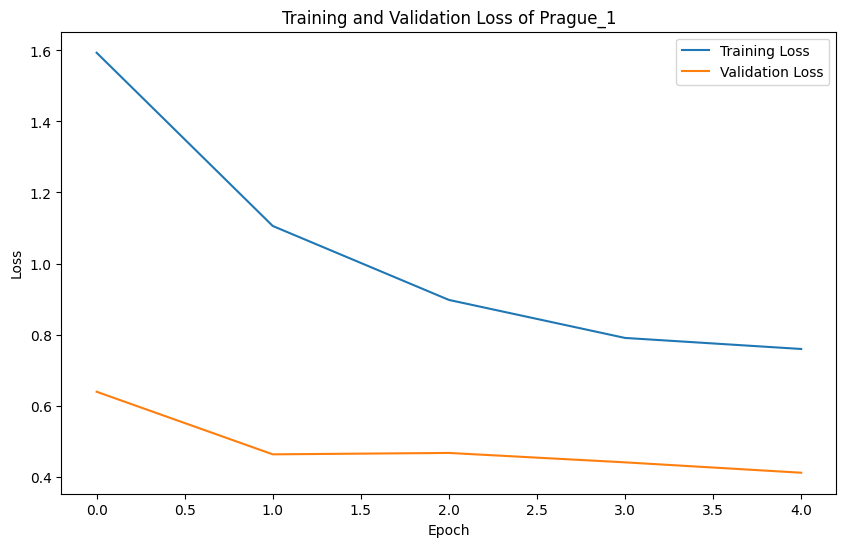

Training model for warehouse: Prague_2
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.577677 -1.211889     1.483102         -1.732070  -0.30871 -2.145151   
1  1.577677 -1.097922     1.492208         -1.729174  -0.30871 -2.145151   
2  1.577677 -0.983955     1.501315         -1.726278  -0.30871 -2.145151   
3  1.577677 -0.869988     1.510421         -1.723382  -0.30871 -2.145151   
4  1.577677 -0.756021     1.519528         -1.720486  -0.30871 -2.145151   

   month_sin  month_cos  orders_lag_28  orders_lag_56  orders_lag_168  \
0  -0.595108   1.577677      -4.976762      -3.919607       -2.366881   
1  -0.595108   1.577677      -4.976762      -3.919607       -2.366881   
2  -0.595108   1.577677      -4.976762      -3.919607       -2.366881   
3  -0.595108   1.577677      -4.976762      -3.919607       -2.366881   
4  -0.595108   1.577677      -4.976762      -3.919607       -2.366881   

   orders_lag_364  orders_rolling_mean_28  orders_rolling_std_28 

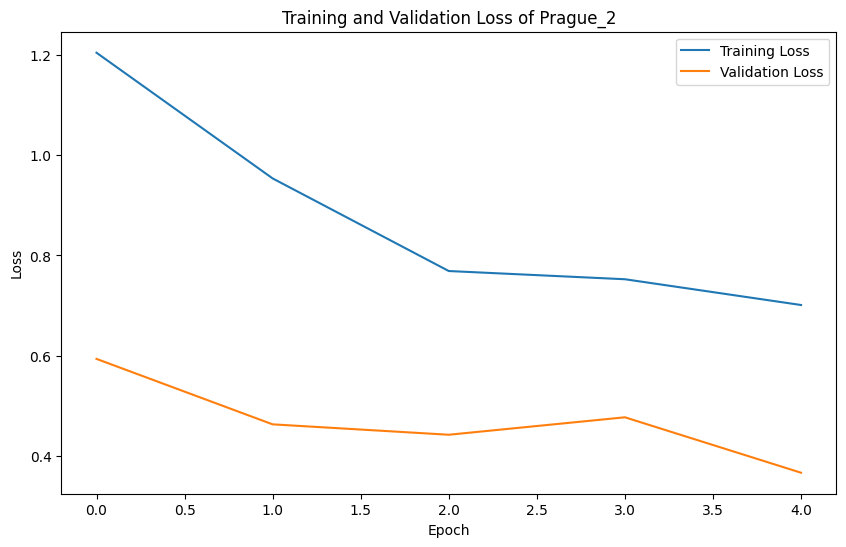

Training model for warehouse: Prague_3
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  1.577677 -1.211889     1.483102         -1.732070  -0.30871 -2.145151   
1  1.577677 -1.097922     1.492208         -1.729174  -0.30871 -2.145151   
2  1.577677 -0.983955     1.501315         -1.726278  -0.30871 -2.145151   
3  1.577677 -0.869988     1.510421         -1.723382  -0.30871 -2.145151   
4  1.577677 -0.756021     1.519528         -1.720486  -0.30871 -2.145151   

   month_sin  month_cos  orders_lag_28  orders_lag_56  orders_lag_168  \
0  -0.595108   1.577677      -5.029457       -3.93607       -2.367067   
1  -0.595108   1.577677      -5.029457       -3.93607       -2.367067   
2  -0.595108   1.577677      -5.029457       -3.93607       -2.367067   
3  -0.595108   1.577677      -5.029457       -3.93607       -2.367067   
4  -0.595108   1.577677      -5.029457       -3.93607       -2.367067   

   orders_lag_364  orders_rolling_mean_28  orders_rolling_std_28 

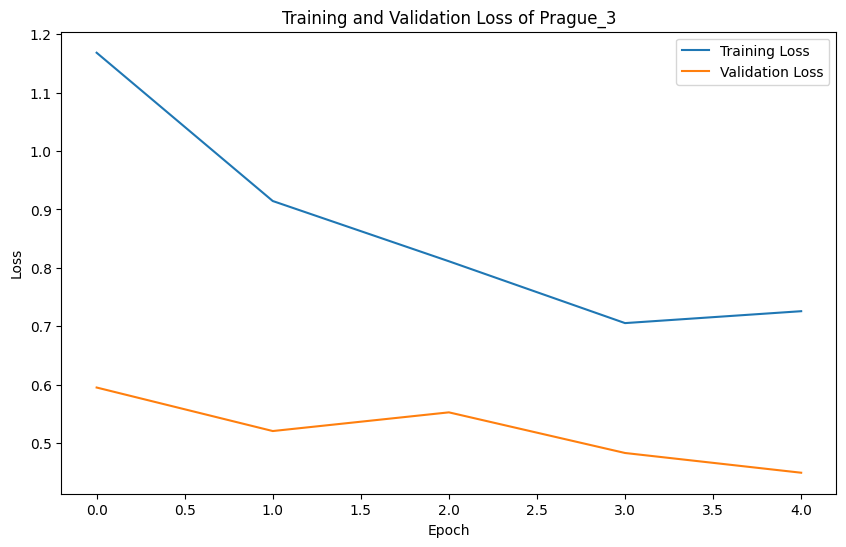

Training model for warehouse: Munich_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0  0.083277  0.588953     0.122178         -1.818241  1.321338 -1.672567   
1  0.083277  1.503095     0.194412         -1.788946  1.321338 -1.672567   
2  0.359112 -1.125065     0.266647         -1.759652  1.321338 -1.672567   
3  0.359112 -0.325190     0.329852         -1.734019  1.321338 -1.672567   
4  0.359112 -0.210922     0.338881         -1.730357  1.321338 -1.672567   

   month_sin  month_cos  orders_lag_28  orders_lag_56  orders_lag_168  \
0   0.322976   0.083277      -2.371077      -2.198492       -1.643161   
1   0.322976   0.083277      -2.371077      -2.198492       -1.643161   
2   0.200314   0.359112      -2.371077      -2.198492       -1.643161   
3   0.200314   0.359112      -2.371077      -2.198492       -1.643161   
4   0.200314   0.359112      -2.371077      -2.198492       -1.643161   

   orders_lag_364  orders_rolling_mean_28  orders_rolling_std_28 

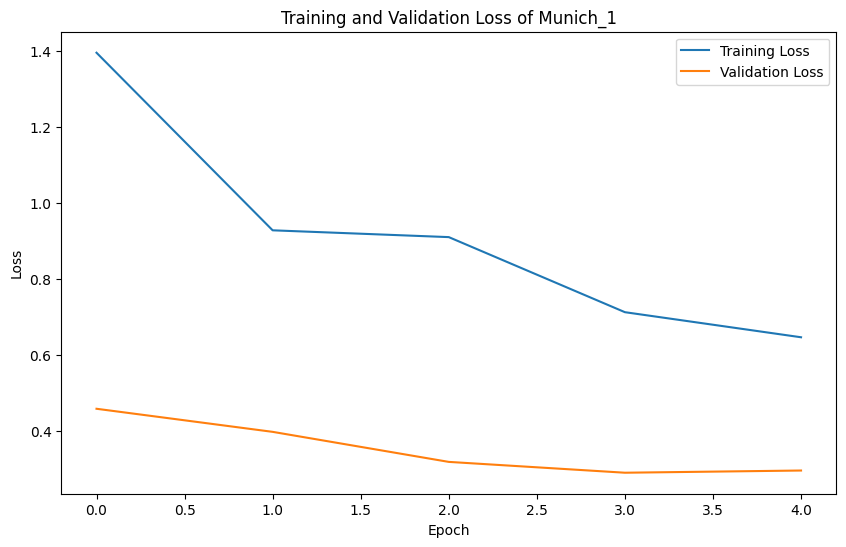

Training model for warehouse: Frankfurt_1
      month       day  day_of_year  days_since_start  year_sin  year_cos  \
0 -1.265564  0.261037    -1.226255         -1.742215 -1.058147 -1.058326   
1 -1.265564  0.374980    -1.216808         -1.737629 -1.058147 -1.058326   
2 -1.265564  0.830753    -1.179023         -1.719286 -1.058147 -1.058326   
3 -1.265564  0.944696    -1.169577         -1.714700 -1.058147 -1.058326   
4 -1.265564  1.058639    -1.160130         -1.710114 -1.058147 -1.058326   

   month_sin  month_cos  orders_lag_28  orders_lag_56  orders_lag_168  \
0   0.648776  -1.265564      -2.767371      -2.303716       -1.517432   
1   0.648776  -1.265564      -2.767371      -2.303716       -1.517432   
2   0.648776  -1.265564      -2.767371      -2.303716       -1.517432   
3   0.648776  -1.265564      -2.767371      -2.303716       -1.517432   
4   0.648776  -1.265564      -2.767371      -2.303716       -1.517432   

   orders_lag_364  orders_rolling_mean_28  orders_rolling_std_

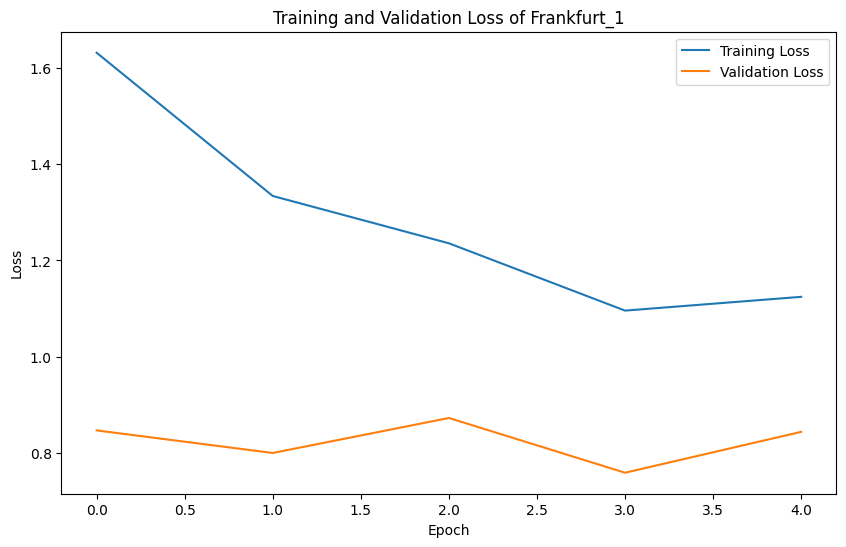

In [241]:
for warehouse in warehouses:
    print(f"Training model for warehouse: {warehouse}")
    
    warehouse_data = train_df[train_df['warehouse'] == warehouse]
    
    X_train, y_train, x_scaler, y_scaler = preprocess_data(warehouse_data, warehouse)
    print(X_train.head())
    # Create sequences
    X_seq, y_seq = create_sequences(X_train, y_train, time_steps=28)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True)  # Do not shuffle time series data
    
    # Create and train model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train, 
        epochs=5, 
        batch_size=8, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    
    plot_loss(history)


## Inference

In [242]:
import os

#### MAPE

Predicting for warehouse: Brno_1
final shape: ((1165, 28, 39), (1165, 1))
37/37 [==============================] - 1s 6ms/step


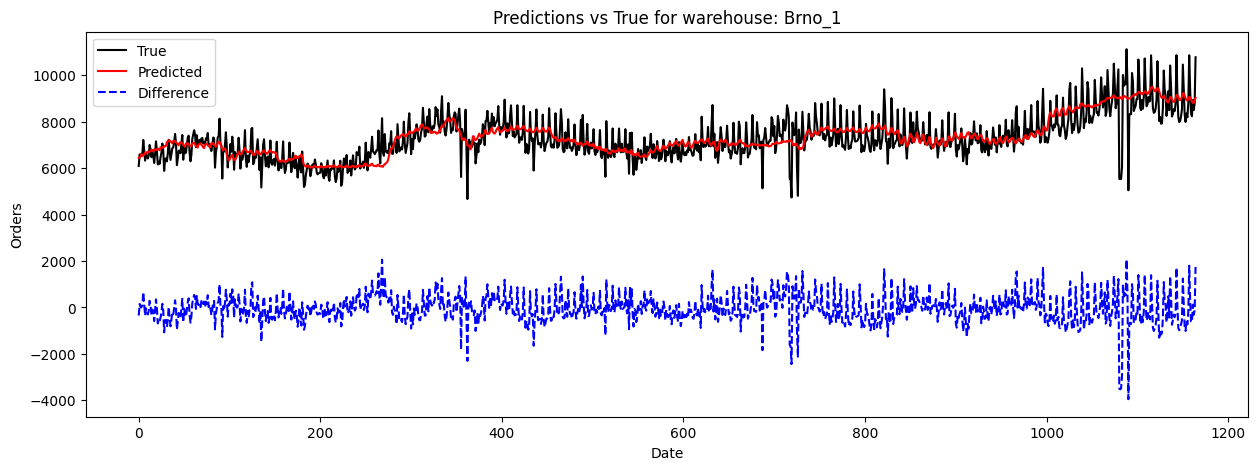


Mean Absolute Percentage Error for Brno_1: 6.1467%
Predicting for warehouse: Budapest_1
final shape: ((1126, 28, 39), (1126, 1))
36/36 [==============================] - 1s 6ms/step


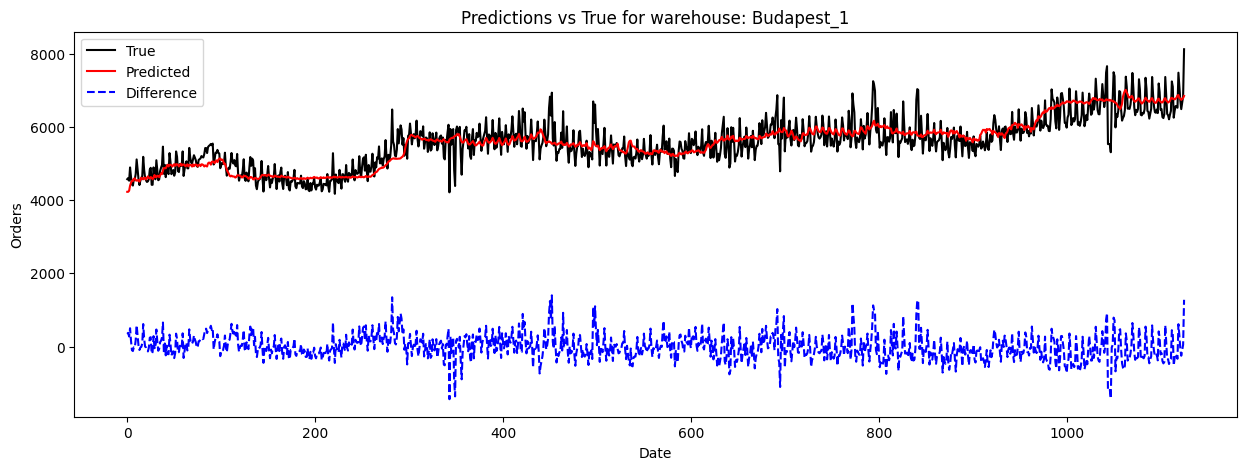


Mean Absolute Percentage Error for Budapest_1: 4.6144%
Predicting for warehouse: Prague_1
final shape: ((1165, 28, 39), (1165, 1))
37/37 [==============================] - 1s 7ms/step


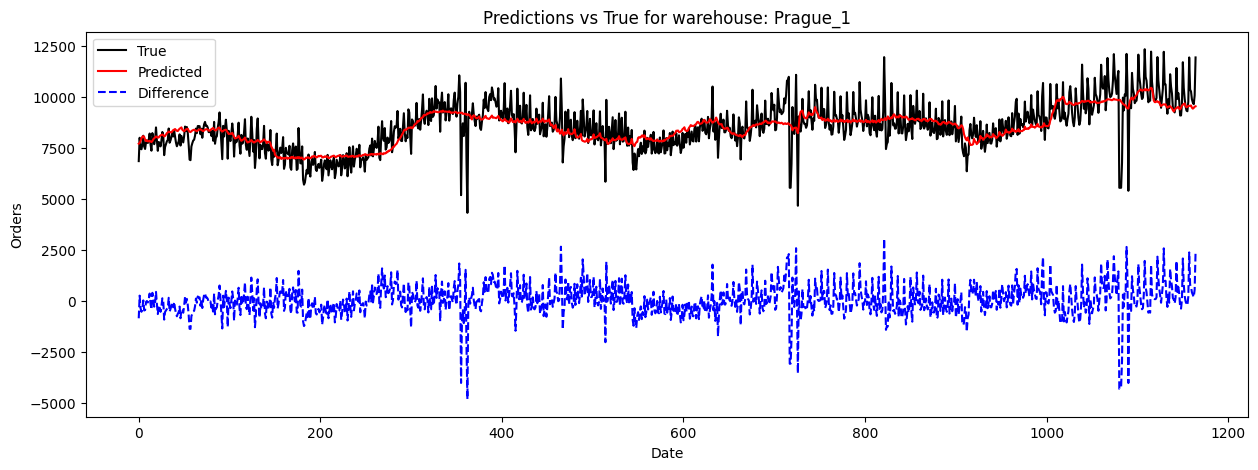


Mean Absolute Percentage Error for Prague_1: 6.4875%
Predicting for warehouse: Prague_2
final shape: ((1165, 28, 39), (1165, 1))
37/37 [==============================] - 1s 7ms/step


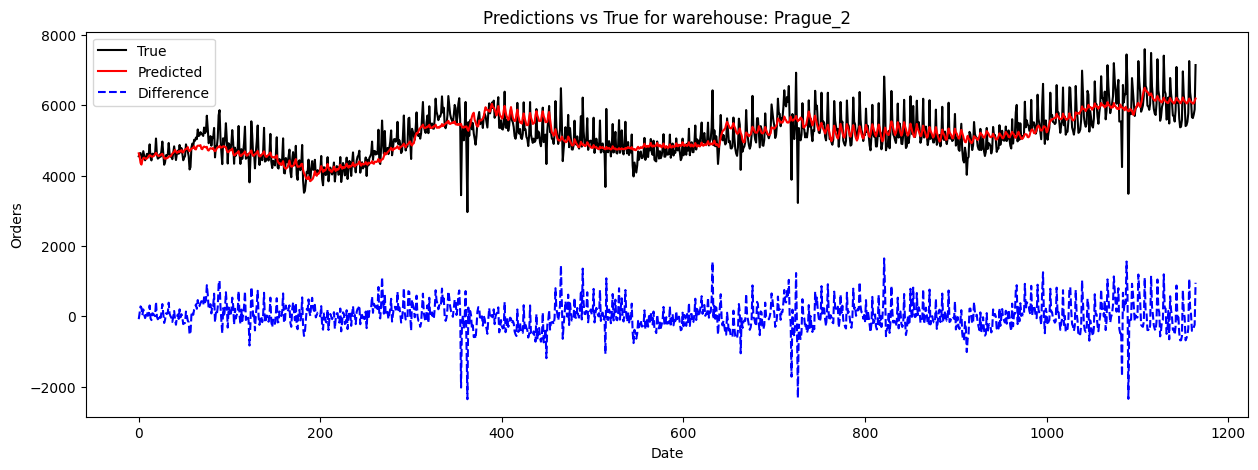


Mean Absolute Percentage Error for Prague_2: 5.5523%
Predicting for warehouse: Prague_3
final shape: ((1165, 28, 39), (1165, 1))
37/37 [==============================] - 1s 6ms/step


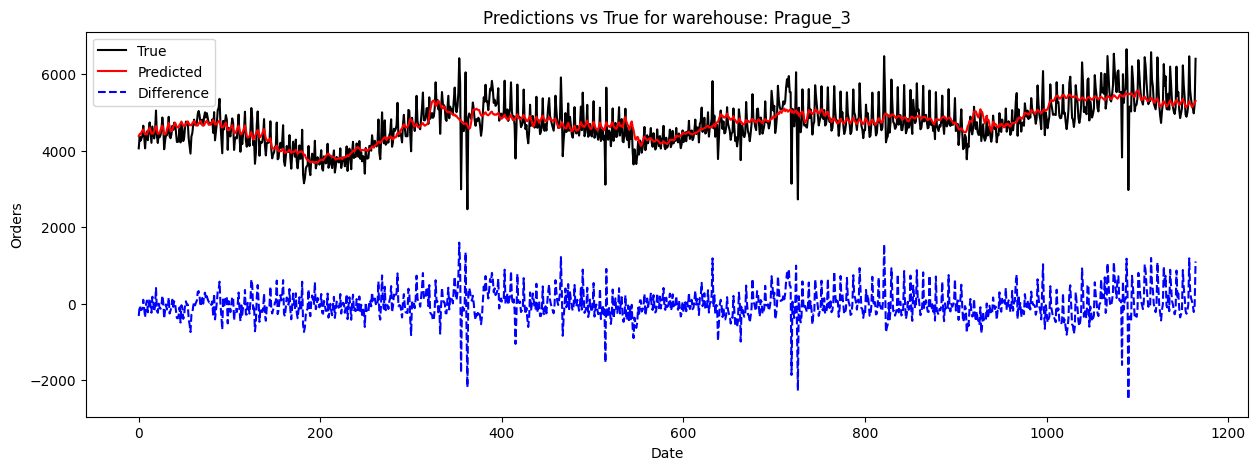


Mean Absolute Percentage Error for Prague_3: 5.7797%
Predicting for warehouse: Munich_1
final shape: ((757, 28, 39), (757, 1))
24/24 [==============================] - 1s 7ms/step


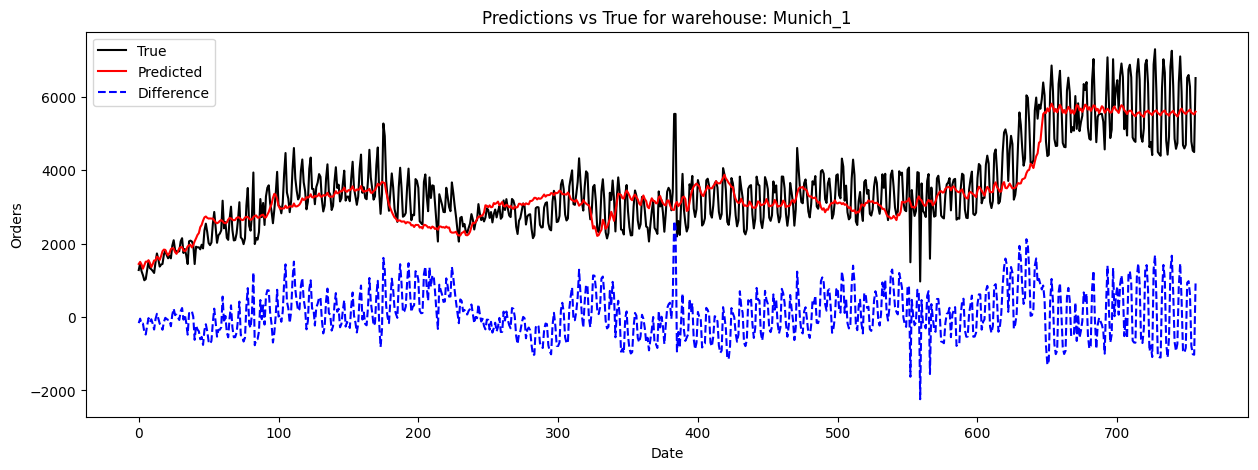


Mean Absolute Percentage Error for Munich_1: 15.1356%
Predicting for warehouse: Frankfurt_1
final shape: ((601, 28, 39), (601, 1))
19/19 [==============================] - 1s 6ms/step


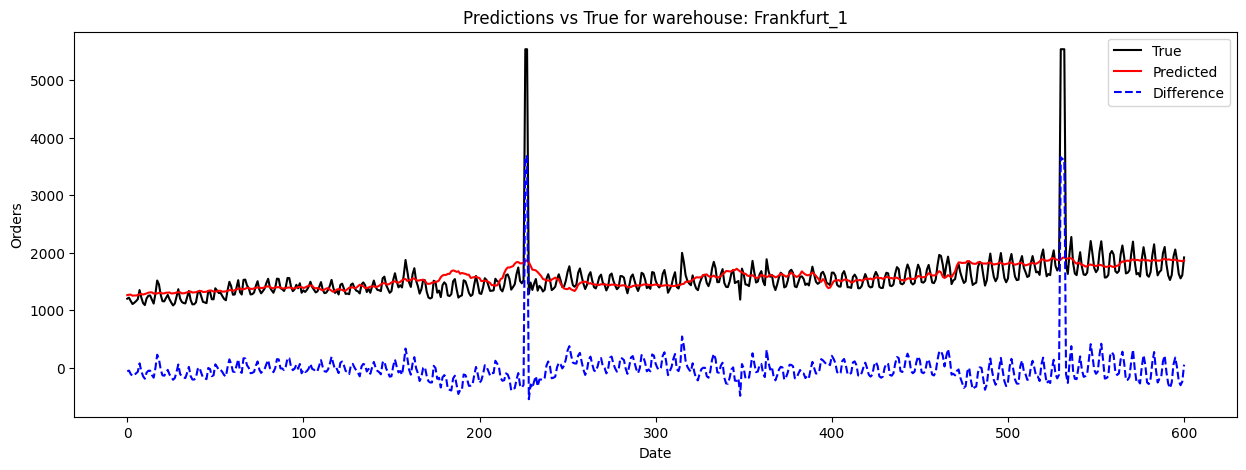


Mean Absolute Percentage Error for Frankfurt_1: 9.0964%

MAPE scores: 
Brno_1: 6.1467%
Budapest_1: 4.6144%
Prague_1: 6.4875%
Prague_2: 5.5523%
Prague_3: 5.7797%
Munich_1: 15.1356%
Frankfurt_1: 9.0964%

Mean MAPE: 7.5447%


In [243]:
# Predict and visualise MAPE for each warehouse with its model and scaler:
mape_scores = []

for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    
    warehouse_data = train_df[train_df['warehouse'] == warehouse]
    
    X_train, y_train, x_scaler, y_scaler = preprocess_data(warehouse_data, warehouse)
    
    # Create sequences
    X_seq, y_seq = create_sequences(X_train, y_train, time_steps=28)
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.h5')
    
    # Predict
    predictions = model.predict(X_seq)
    predictions = y_scaler.inverse_transform(predictions)
    y_seq_unscaled = y_scaler.inverse_transform(y_seq)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_seq_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_seq_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_seq_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error for {warehouse}: {mape:.4f}%')

print("\nMAPE scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean MAPE: {np.mean(mape_scores):.4f}%")   

## Inference:

In [244]:
# test data preprocessig function without lag, roll features and no "orders" influence:
def inference_preprocess(dataframe, ohsc, cat_col, bin_col):

    # Encode categorical features
    encoded_categorical_features = ohsc.transform(dataframe[cat_col])
    encoded_feature_names = ohsc.get_feature_names_out(cat_col)
    dataframe_encoded = pd.DataFrame(encoded_categorical_features, columns=encoded_feature_names, index=dataframe.index)

    dataframe = pd.concat([dataframe, dataframe_encoded], axis=1)

    dataframe = dataframe.drop(columns=cat_col)
    
    date = dataframe.pop('date')

    dataframe_bin = dataframe[bin_col]
    dataframe = dataframe.drop(columns=bin_col)
    warehouse_col = dataframe.pop('warehouse')
    
    df_trans = x_scaler.transform(dataframe)
        
    dataframe = pd.DataFrame(df_trans, columns=dataframe.columns)
    dataframe_bin = dataframe_bin.reset_index(drop=True)
    dataframe = pd.concat([dataframe, dataframe_bin], axis=1)
    warehouse_col = warehouse_col.reset_index(drop=True)
    dataframe = pd.concat([dataframe, warehouse_col], axis=1)
    dataframe.index = date
    
    return dataframe

In [245]:
dataframe = pd.read_csv("data/test_proc_mt.csv")
dataframe.head(10)

,date,warehouse,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,date.1
0,2024-03-16,Brno_1,0,0,0,0,Brno_1_2024-03-16,1,2024,3,16,5,76,1,1197,3.208798e-11,2024.0,-2.204364e-15,3.0,9529.0,9512.0,8045.0,7910.0,8840.148148,894.793818,8620.552884,1038.744030,7923.549123,1038.261319,2024-03-16
1,2024-03-16,Budapest_1,0,0,0,0,Budapest_1_2024-03-16,1,2024,3,16,5,76,1,1197,3.208798e-11,2024.0,-2.204364e-15,3.0,7193.0,7481.0,5839.0,6047.0,6698.555556,460.185191,6504.355279,459.275653,6119.761244,552.134147,2024-03-16
2,2024-03-16,Frankfurt_1,0,0,0,0,Frankfurt_1_2024-03-16,1,2024,3,16,5,76,1,1197,3.208798e-11,2024.0,-2.204364e-15,3.0,1623.0,1652.0,1427.0,1354.0,1779.333333,194.642078,1797.427135,541.844770,1649.499536,402.229296,2024-03-16
3,2024-03-16,Munich_1,0,0,0,0,Munich_1_2024-03-16,1,2024,3,16,5,76,1,1197,3.208798e-11,2024.0,-2.204364e-15,3.0,4499.0,5627.0,3906.0,2448.0,5585.259259,1035.386386,5165.277435,1156.254636,4126.981630,1304.648225,2024-03-16
4,2024-03-16,Prague_1,0,0,0,0,Prague_1_2024-03-16,1,2024,3,16,5,76,1,1197,3.208798e-11,2024.0,-2.204364e-15,3.0,10488.0,10968.0,8806.0,9817.0,10013.259259,820.309960,9858.289411,1132.741632,9168.708903,1135.970268,2024-03-16
5,2024-03-16,Prague_2,0,0,0,0,Prague_2_2024-03-16,1,2024,3,16,5,76,1,1197,3.208798e-11,2024.0,-2.204364e-15,3.0,6327.0,6554.0,5395.0,5901.0,5978.481481,556.012200,5957.463064,604.611101,5541.193751,644.926369,2024-03-16
6,2024-03-16,Prague_3,0,0,0,0,Prague_3_2024-03-16,1,2024,3,16,5,76,1,1197,3.208798e-11,2024.0,-2.204364e-15,3.0,5753.0,6211.0,4942.0,5207.0,5352.444444,469.253772,5372.043902,530.767178,5047.033971,549.088483,2024-03-16
7,2024-03-17,Brno_1,0,0,0,0,Brno_1_2024-03-17,1,2024,3,17,6,77,1,1198,3.208798e-11,2024.0,-2.204364e-15,3.0,8222.0,8668.0,7117.0,7432.0,8863.923077,903.775455,8629.610431,1035.251136,7924.906993,1039.375544,2024-03-17
8,2024-03-17,Budapest_1,0,0,0,0,Budapest_1_2024-03-17,1,2024,3,17,6,77,1,1198,3.208798e-11,2024.0,-2.204364e-15,3.0,6956.0,7075.0,5890.0,5635.0,6688.653846,466.356254,6508.056215,458.160742,6121.100364,552.307733,2024-03-17
9,2024-03-17,Prague_1,0,0,0,0,Prague_1_2024-03-17,1,2024,3,17,6,77,1,1198,3.208798e-11,2024.0,-2.204364e-15,3.0,10159.0,10780.0,7879.0,8544.0,10007.653846,836.027796,9870.212841,1125.608285,9170.434618,1137.065962,2024-03-17


In [246]:
# load scaler config:
scaler_config = joblib.load('scaler_config_mt.joblib')
ohsc = joblib.load("scaler_onehot_categorical_mt.joblib")

cat_features = scaler_config['cat_features']
bin_features = scaler_config['bin_features']
    
print(f"cat_features: {cat_features}")
print(f"binary_features: {bin_features}")

cat_features: ['day_of_week', 'quarter', 'year']
binary_features: ['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']


In [247]:
id = dataframe.pop('id')
dataframe.drop(columns=['date.1'], inplace=True)
processed_data = inference_preprocess(dataframe, ohsc, cat_features, bin_features)

In [262]:
print(len(processed_data.columns))

40


In [257]:
# Compare the columns in the original and processed dataframes

X_columns = set(X_train.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("this df has the same columns as the training df.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in train_df:")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in processed_data:")
        print(columns_only_in_processed_data)

The dataframes have different columns.
Columns present only in processed_data:
{'warehouse'}


In [249]:
processed_data = processed_data.fillna(0)

In [250]:
processed_data.head(10)

,month,day,day_of_year,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024,is_weekend,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-16,-0.977144,0.033150,-0.971203,1.729230,2.031441,2.030709,0.605644,-0.977144,15.442024,13.738716,10.135170,10.193420,30.012341,2.348682,36.008600,4.398858,38.812058,5.945516,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,0.0,1.610679,-0.547345,-0.579186,-0.562049,0.0,0.0,-0.844924,-0.964079,2.971216,1,0,0,0,0,Brno_1
2024-03-16,-0.977144,0.033150,-0.971203,1.729230,2.031441,2.030709,0.605644,-0.977144,10.978057,10.313339,6.939938,7.605109,21.243968,0.848479,25.414661,1.108211,28.126801,2.148320,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,0.0,1.610679,-0.547345,-0.579186,-0.562049,0.0,0.0,-0.844924,-0.964079,2.971216,1,0,0,0,0,Budapest_1
2024-03-16,-0.977144,0.033150,-0.971203,1.729230,2.031441,2.030709,0.605644,-0.977144,0.334093,0.482459,0.549475,1.085010,1.103083,-0.068136,1.851215,1.577099,1.645919,0.977396,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,0.0,1.610679,-0.547345,-0.579186,-0.562049,0.0,0.0,-0.844924,-0.964079,2.971216,1,0,0,0,0,Frankfurt_1
2024-03-16,-0.977144,0.033150,-0.971203,1.729230,2.031441,2.030709,0.605644,-0.977144,5.829971,7.186482,4.140127,2.604930,16.685773,2.833986,18.711077,5.066170,16.321997,8.026295,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,0.0,1.610679,-0.547345,-0.579186,-0.562049,0.0,0.0,-0.844924,-0.964079,2.971216,1,0,0,0,0,Munich_1
2024-03-16,-0.977144,0.033150,-0.971203,1.729230,2.031441,2.030709,0.605644,-0.977144,17.274621,16.194328,11.237424,12.842862,34.815437,2.091575,42.204858,4.932646,46.188121,6.708731,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,0.0,1.610679,-0.547345,-0.579186,-0.562049,0.0,0.0,-0.844924,-0.964079,2.971216,1,0,0,0,0,Prague_1
2024-03-16,-0.977144,0.033150,-0.971203,1.729230,2.031441,2.030709,0.605644,-0.977144,9.323178,8.749911,6.296836,7.402267,18.295752,1.179259,22.676853,1.933532,24.699490,2.873131,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,0.0,1.610679,-0.547345,-0.579186,-0.562049,0.0,0.0,-0.844924,-0.964079,2.971216,1,0,0,0,0,Prague_2
2024-03-16,-0.977144,0.033150,-0.971203,1.729230,2.031441,2.030709,0.605644,-0.977144,8.226296,8.171425,5.640699,6.438076,15.732554,0.879782,19.746175,1.514192,21.772192,2.124530,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,0.0,1.610679,-0.547345,-0.579186,-0.562049,0.0,0.0,-0.844924,-0.964079,2.971216,1,0,0,0,0,Prague_3
2024-03-17,-0.977144,0.147094,-0.961757,1.733816,2.031441,2.030709,0.605644,-0.977144,12.944419,12.315270,8.791029,9.529323,30.109683,2.379685,36.053943,4.379023,38.820102,5.954219,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,1.0,1.610679,-0.547345,-0.579186,-0.562049,0.0,0.0,-0.844924,-0.964079,2.971216,1,0,0,0,0,Brno_1
2024-03-17,-0.977144,0.147094,-0.961757,1.733816,2.031441,2.030709,0.605644,-0.977144,10.525163,9.628601,7.013808,7.032707,21.203427,0.869780,25.433189,1.101879,28.134734,2.149676,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,1.0,1.610679,-0.547345,-0.579186,-0.562049,0.0,0.0,-0.844924,-0.964079,2.971216,1,0,0,0,0,Budapest_1


In [251]:
processed_data.describe()

,month,day,day_of_year,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4,year_2020,year_2021,year_2022,year_2023,year_2024,is_weekend,holiday,shops_closed,winter_school_holidays,school_holidays
count,397.000000,397.000000,397.000000,397.000000,3.970000e+02,3.970000e+02,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,3.970000e+02,397.000000,397.0,397.0,3.970000e+02,3.970000e+02,3.970000e+02,397.000000,397.000000,397.000000,397.000000,397.000000
mean,-0.693083,0.008755,-0.687098,1.867150,2.031441e+00,2.030709e+00,0.542000,-0.693083,4.602889,8.239650,7.078240,6.803042,9.630240,0.748654,25.232359,2.877674,26.599118,4.191124,-0.012875,-0.017905,-0.054539,-0.078930,-0.097437,-0.034501,0.110831,-0.047515,1.216967,-5.791860e-01,-0.562049,0.0,0.0,-8.449239e-01,-9.640788e-01,2.971216e+00,0.269521,0.068010,0.020151,0.020151,0.070529
std,0.203897,0.984862,0.166395,0.080777,8.892992e-16,4.446496e-16,0.048886,0.203897,5.798375,4.590203,3.489218,3.188256,12.449756,1.060974,11.917304,1.557662,13.257645,2.482453,0.988867,0.984816,0.950972,0.923965,0.906354,0.970109,0.314319,0.976274,1.038753,1.111624e-16,0.000000,0.0,0.0,2.223248e-16,2.223248e-16,4.446496e-16,0.444271,0.252081,0.140694,0.140694,0.256359
min,-0.977144,-1.675998,-0.971203,1.729230,2.031441e+00,2.030709e+00,0.467621,-0.977144,0.000000,0.000000,0.536439,1.000261,0.000000,-0.177000,1.851215,1.036758,1.645919,0.977396,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,0.000000,-0.620856,-0.547345,-5.791860e-01,-0.562049,0.0,0.0,-8.449239e-01,-9.640788e-01,2.971216e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.977144,-0.878395,-0.829508,1.798017,2.031441e+00,2.030709e+00,0.545259,-0.977144,0.000000,6.188046,5.503098,5.289105,0.000000,0.000000,20.072461,1.548168,21.782544,2.167293,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,0.000000,-0.620856,-0.547345,-5.791860e-01,-0.562049,0.0,0.0,-8.449239e-01,-9.640788e-01,2.971216e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.688724,0.033150,-0.687812,1.866804,2.031441e+00,2.030709e+00,0.545259,-0.688724,0.000000,8.367065,6.925454,6.757621,0.000000,0.000000,23.242403,1.950888,24.912907,2.918435,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,0.000000,-0.620856,1.827001,-5.791860e-01,-0.562049,0.0,0.0,-8.449239e-01,-9.640788e-01,2.971216e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-0.688724,0.830753,-0.546117,1.935591,2.031441e+00,2.030709e+00,0.605644,-0.688724,9.227631,11.613667,9.846933,9.144480,18.420705,1.331401,36.632265,4.414059,39.026183,6.773389,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,0.000000,1.610679,1.827001,-5.791860e-01,-0.562049,0.0,0.0,-8.449239e-01,-9.640788e-01,2.971216e+00,1.000000,0.000000,0.000000,0.000000,0.000000
max,-0.400303,1.742299,-0.404421,2.004378,2.031441e+00,2.030709e+00,0.605644,-0.400303,20.005361,18.275526,15.235085,15.781282,42.609966,4.180693,43.381921,5.593231,46.594703,8.217777,2.327739,2.246793,2.196377,2.246793,2.208734,2.196377,1.000000,1.610679,1.827001,-5.791860e-01,-0.562049,0.0,0.0,-8.449239e-01,-9.640788e-01,2.971216e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [252]:
# Load warehouse models and scalers
warehouses = processed_data['warehouse'].unique()
warehouse_models = {}
for wh in warehouses:
    model = tf.keras.models.load_model(f'model_{wh}.h5')
    x_scaler = joblib.load(f'x_scaler_{wh}.joblib')
    y_scaler = joblib.load(f'y_scaler_{wh}.joblib')
    warehouse_models[wh] = {'model': model, 'x_scaler': x_scaler, 'y_scaler': y_scaler}

In [264]:
def variable_length_predict(data, max_time_steps, feature_columns, warehouse_models):
    predictions = []
    for i in range(len(data)):
        wh = data.iloc[i]['warehouse']
        model = warehouse_models[wh]['model']
        x_scaler = warehouse_models[wh]['x_scaler']
        y_scaler = warehouse_models[wh]['y_scaler']
        
        seq_len = min(max_time_steps, i+1)
        sequence = data[feature_columns].iloc[max(0, i-seq_len+1):i+1]
        
        if len(sequence) < max_time_steps:
            padding = pd.DataFrame([sequence.iloc[0]] * (max_time_steps - len(sequence)), 
                                   columns=sequence.columns)
            sequence = pd.concat([padding, sequence]).reset_index(drop=True)
        
        
        # Scale the sequence
        scale_columns = sequence.columns.difference(bin_features)
        
        scaled_sequence = x_scaler.transform(sequence[scale_columns])
        
        # Reshape the sequence for the model
        model_input = scaled_sequence.reshape(1, max_time_steps, -1)
        
        # Make prediction and rescale
        pred = model.predict(model_input)
        pred_rescaled = y_scaler.inverse_transform(pred)
        predictions.append(pred_rescaled[0][0])
    
    return np.array(predictions)

In [265]:
# Make predictions
time_steps = 28
feature_columns = [col for col in processed_data.columns if col not in ['id', 'date', 'warehouse']]
predictions = variable_length_predict(processed_data, time_steps, feature_columns, warehouse_models)


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'orders': predictions,
    'date': test_df['date'],
    'warehouse': test_df['warehouse']
})

# Save submission CSV
submission_df.to_csv('submission_multi_warehouse.csv', index=False)

In [ ]:
# Plot predictions for each warehouse
for wh in warehouses:
    plt.figure(figsize=(15, 6))
    
    # Plot predicted data
    wh_df = submission_df[submission_df['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', color='red')
    
    # Plot actual data (training data from 2023)
    wh_df_train = train_df_raw[(train_df_raw['warehouse'] == wh) & (train_df_raw['date'].dt.year >= 2023)]
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='black')
    
    plt.title(f'Predicted vs Actual Orders for {wh}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'prediction_plot_{wh}.png')
    plt.close()

print("Predictions complete. Submission file and plots created.")

,id,orders
0,Prague_1_2024-03-16,9343.147461
1,Prague_1_2024-03-17,9477.769531
2,Prague_1_2024-03-18,8739.283203
3,Prague_1_2024-03-19,9201.875977
4,Prague_1_2024-03-20,9600.369141
